# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")
import numpy as np
import torch

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [3]:
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    StandardScalerTorch,
    autoencoder_factory,
    generate_2d_sinusoidal_data,
)

In [4]:
from polcanet.polcanet_reports import (
    analyze_latent_feature_importance,
    analyze_latent_space,
    analyze_reconstruction_error,
    linearity_tests_analysis,
    orthogonality_test_analysis,
    plot_cumsum_variance,
    plot_scatter_corr_matrix,
    plot_stdev_pct,
    show_correlation_matrix,
    variance_test_analysis,
)

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

## PolcaNet on Synthetic Sinudosial Images

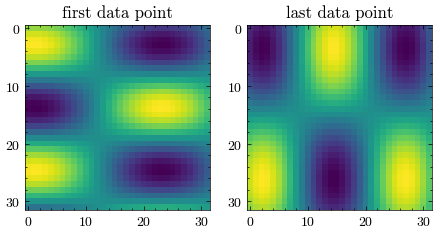

In [7]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data = generate_2d_sinusoidal_data(N, M, num_samples)
data.shape
# Plot original and reconstructed signals for a sample
fig, axes = plt.subplots(1, 2)
axes[0].imshow(data[0], cmap="viridis")
axes[0].set_title("first data point")
axes[1].imshow(data[-1], cmap="viridis")
axes[1].set_title("last data point")
plt.show()

## Create the POLCA-Net

### Create a POLCA-Net with an LSTM Encoder

In [8]:
ae_input = data
act_fn = torch.nn.Mish()
input_dim = ae_input[0].shape
latent_dim = 256
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_lstm = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=256,
    hidden_dim=None,
    num_layers=2,
    autoencoder_type="lstm",
    act_fn=act_fn,
)

decoder_lstm = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=256, num_layers=3)

model_lstm = PolcaNet(
    encoder=encoder_lstm,
    decoder=decoder_lstm,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    scaler=StandardScalerTorch(),
)
model_lstm

PolcaNet(
  (encoder): LSTMAutoencoder(
    (encoder): LSTMEncoder(
      (lstm): LSTM(32, 256, num_layers=2, batch_first=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [9]:
model_lstm.to_device("cuda:3")
model_lstm.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.0003322
Reconstruction Loss: 0.0002248
Orthogonality Loss: 4.753e-05
Center of Mass Loss: 9.822e-05
Variance Distribution Loss: 4.441e-06


In [10]:
model_lstm.train_model(data=data, batch_size=512, num_epochs=1000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.000138
Reconstruction Loss: 4.185e-05
Orthogonality Loss: 4.498e-05
Center of Mass Loss: 8.562e-05
Variance Distribution Loss: 6.022e-06


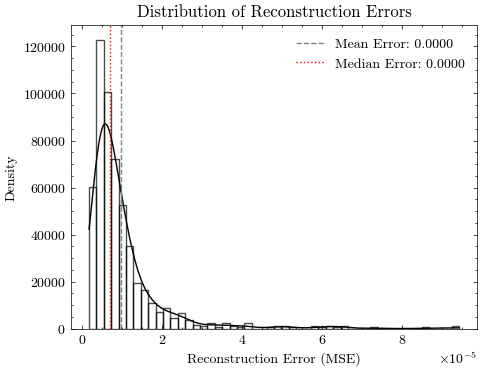

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0001


In [11]:
analyze_reconstruction_error(model_lstm, data, n_samples=1000)

In [12]:
latents, reconstructed = model_lstm.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

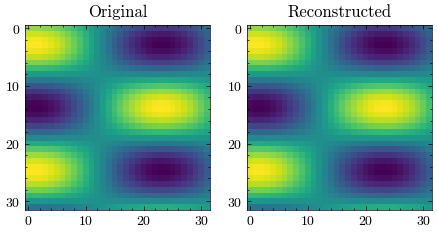

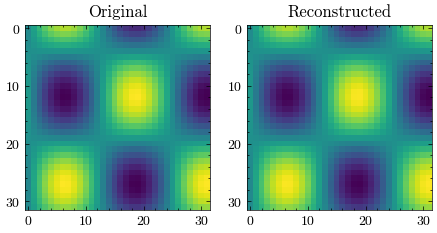

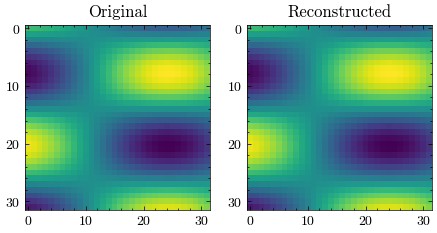

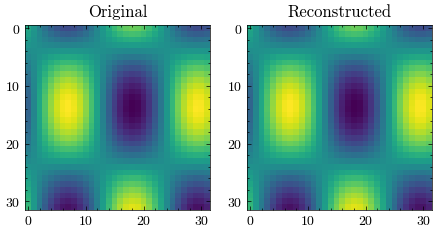

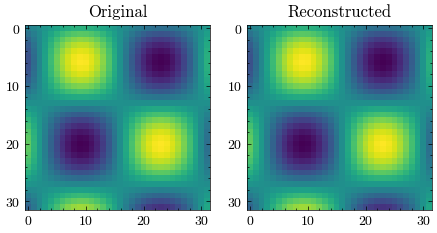

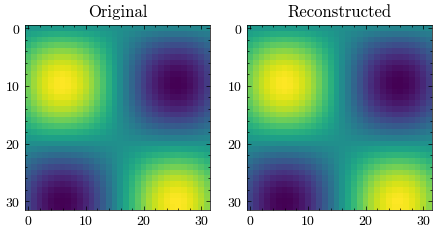

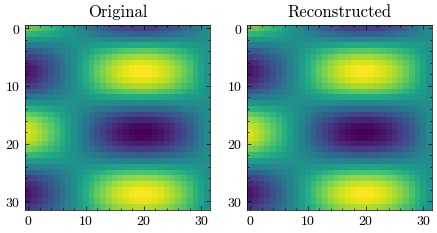

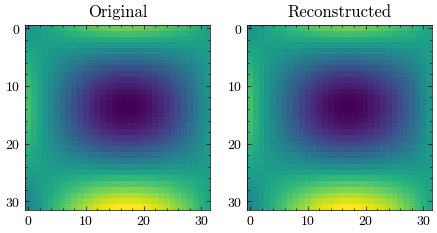

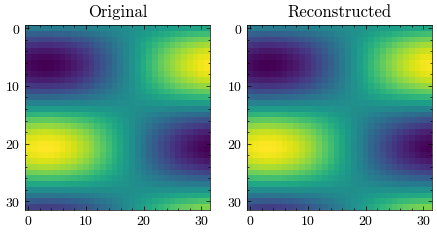

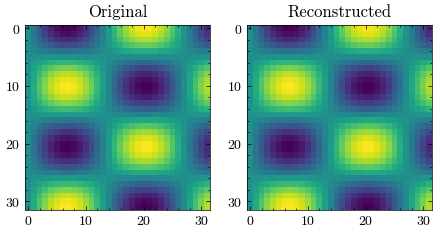

In [13]:
# Plot original and reconstructed signals for a sample
for i in range(10):
    fig, axes = plt.subplots(1, 2, )
    axes[0].imshow(data[i], cmap="viridis")
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed[i], cmap="viridis")
    axes[1].set_title("Reconstructed")
    plt.show()

In [14]:
analyze_latent_space(model_lstm, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 2.3344

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4085
First 5 components              0.9678
Components for 95% variance     5
Variance Concentration Metric   0.995

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.1005
Median absolute off-diagonal          0.0784
Max absolute off-diagonal             0.8234
Proportion of |Orthogonality| > 0.1   0.4007
Orthogonality Success Metric          0.8995

Orthogonality Interpretation:
Good orthogonality, but there might b


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0032
    - Max cosine similarity: 0.9999
    - Min cosine similarity: -0.9998
    


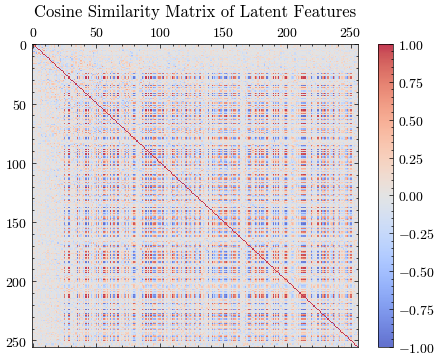

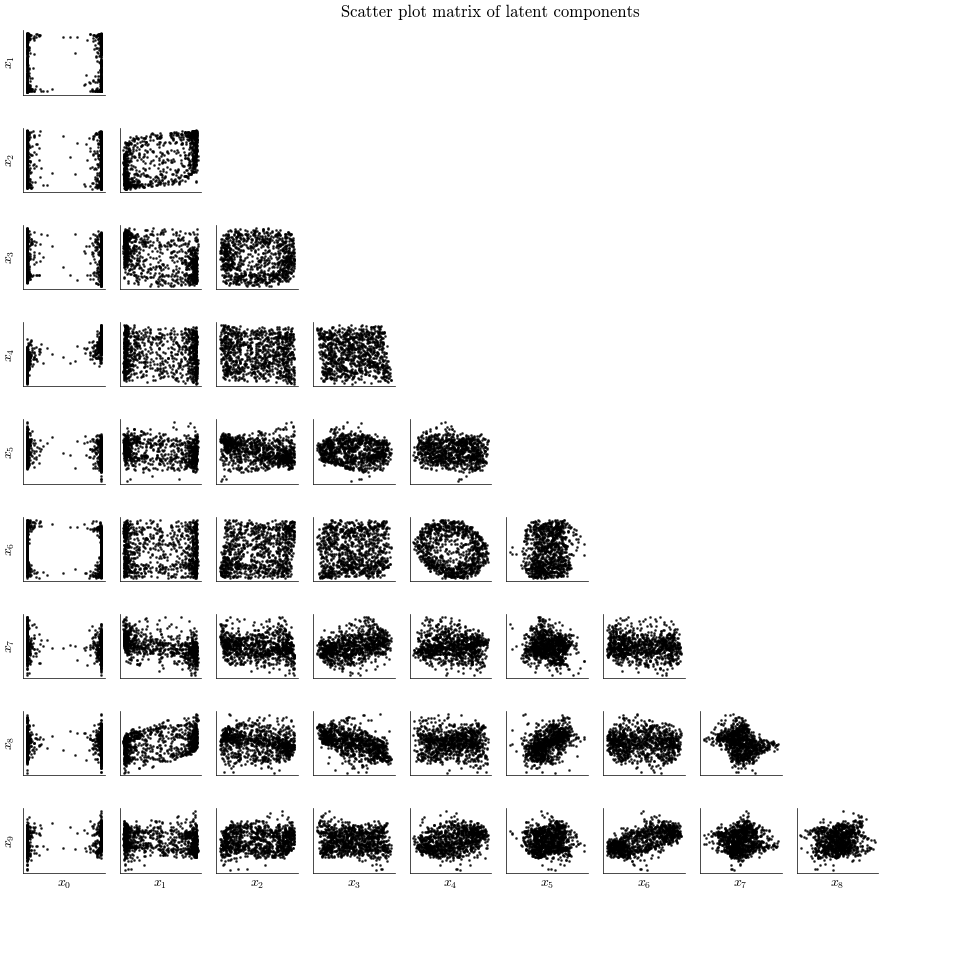

In [15]:
orthogonality_test_analysis(model_lstm, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.2877
    - Variance fit to exponential distribution (sum of squared differences):
     0.0615
    


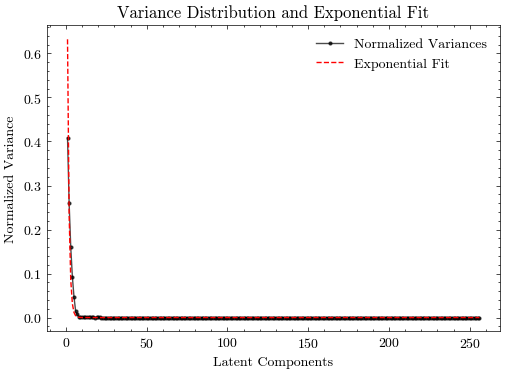

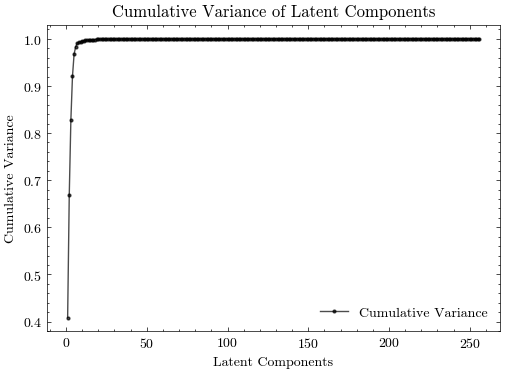

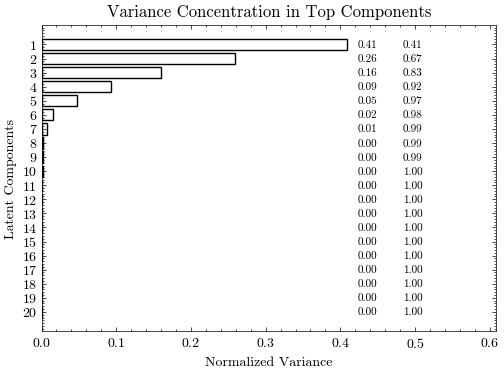

In [16]:
variance_test_analysis(model_lstm, data)

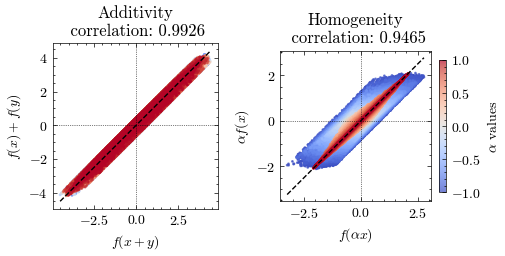

In [17]:
linearity_tests_analysis(model_lstm, data)

---

### Create a POLCA-Net with a 2D Convolutional Encoder

In [18]:
ae_input = data
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0],  #    N
    input_dim=input_dim[1],  #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim * 4, 
                             input_dim=input_dim,
                             hidden_dim=1024,
                             num_layers=2)

model_conv = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim=latent_dim * 4,
    alpha=1.0,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler=StandardScalerTorch(),
)
model_conv

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=256, out_features=256, bias=True)
      (10): SiLU()
      (11): Linear(in_features=256, out_features=256, bias=True)
      (12): SiLU()
      (13): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=1024, bias=True)
    )
  )
  (polcanet_loss): PolcaNetLoss()
)

In [19]:
model_conv.to("cuda:3")
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

/data/conda/envs/python312/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716578970623/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Final metrics at epoch: 9999
Total Loss: 0.0001152
Reconstruction Loss: 3.645e-05
Orthogonality Loss: 5.027e-06
Center of Mass Loss: 6.443e-05
Variance Distribution Loss: 9.286e-06


In [20]:
model_conv.train_model(data=data, batch_size=512, num_epochs=10000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 6.28e-05
Reconstruction Loss: 4.377e-06
Orthogonality Loss: 1.361e-06
Center of Mass Loss: 4.452e-05
Variance Distribution Loss: 1.255e-05


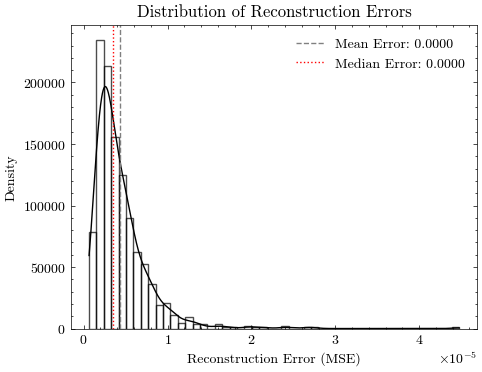

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0000


In [21]:
analyze_reconstruction_error(model_conv, data, n_samples=10000)

In [22]:
latents, reconstructed = model_conv.predict(data)
data.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 256))

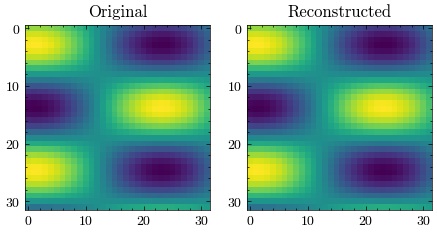

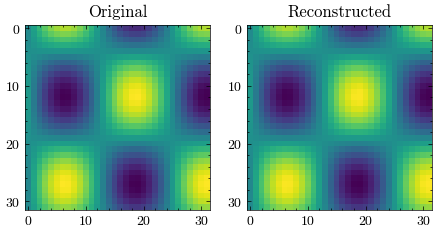

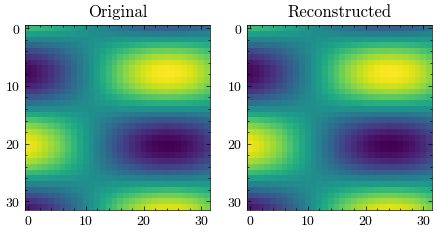

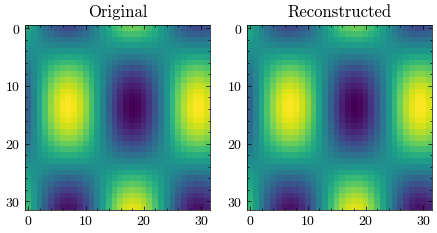

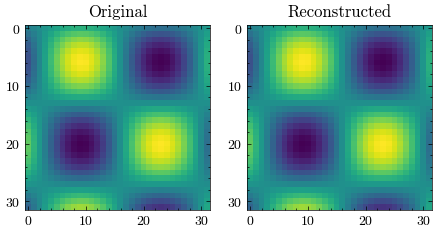

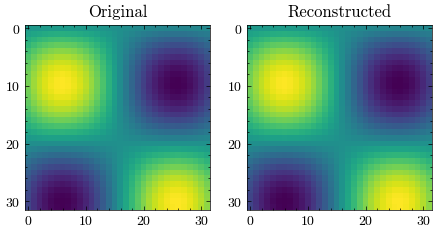

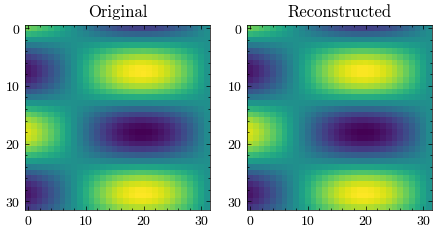

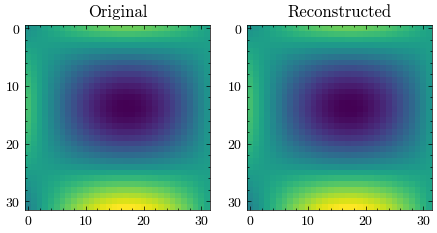

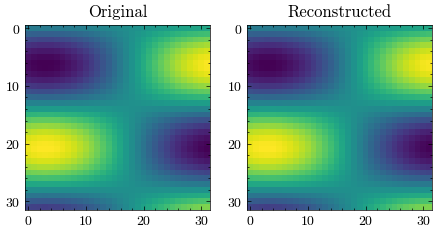

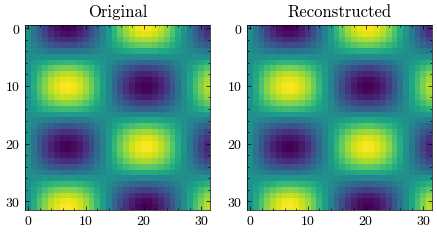

In [23]:
# Plot original and reconstructed signals for a sample
for i in range(10):
    fig, axes = plt.subplots(1, 2, )
    axes[0].imshow(data[i], cmap="viridis")
    axes[0].set_title("Original")
    axes[1].imshow(reconstructed[i], cmap="viridis")
    axes[1].set_title("Reconstructed")
    plt.show()

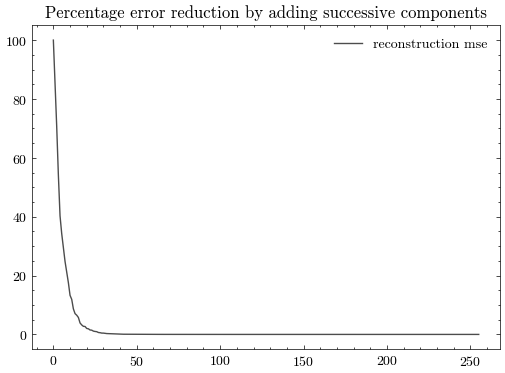

In [24]:
plot_cumsum_variance(model_conv, data)

In [25]:
analyze_latent_space(model_conv, data=data)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 22.6140

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4201
First 5 components              0.9917
Components for 95% variance     5
Variance Concentration Metric   0.9956

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.1118
Median absolute off-diagonal          0.0606
Max absolute off-diagonal             0.7706
Proportion of |Orthogonality| > 0.1   0.3808
Orthogonality Success Metric          0.8882

Orthogonality Interpretation:
Good orthogonality, but there might


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: 0.0017
    - Max cosine similarity: 0.9995
    - Min cosine similarity: -0.9995
    


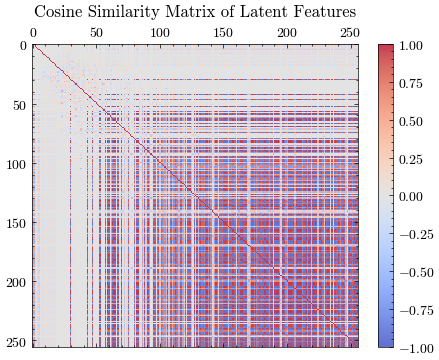

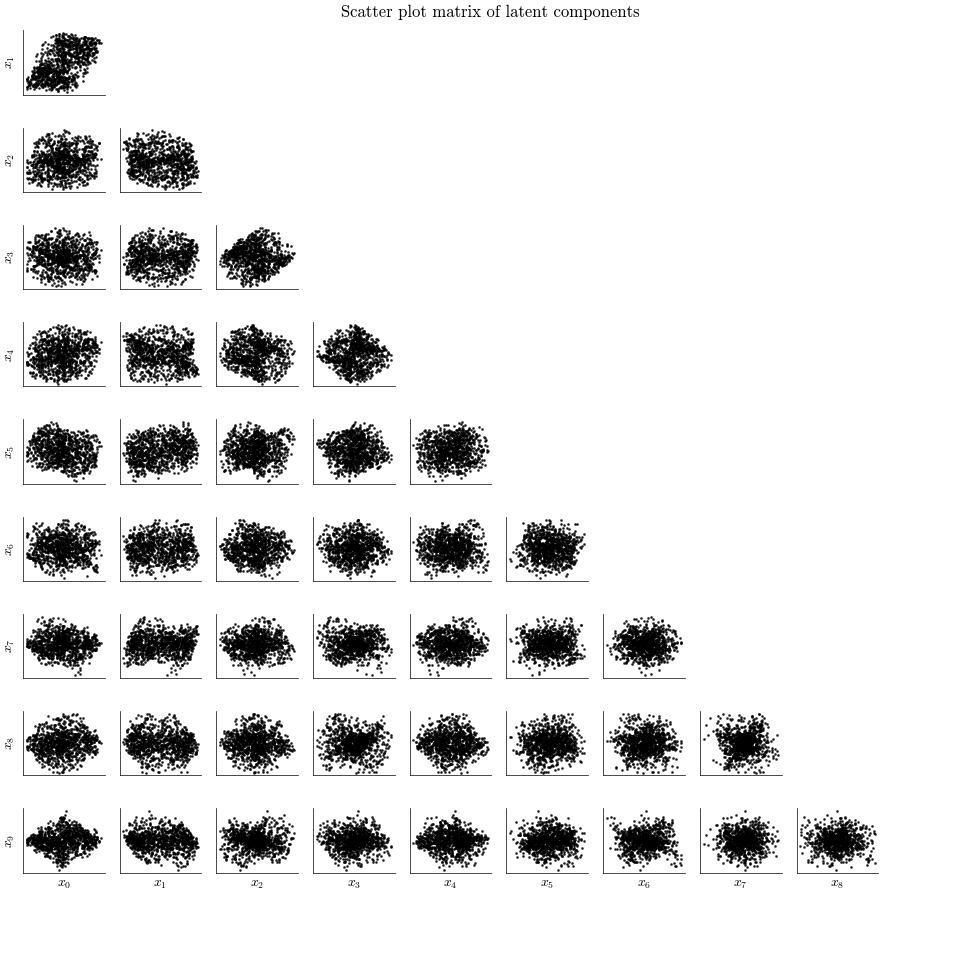

In [26]:
orthogonality_test_analysis(model_conv, data)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 2.1206
    - Variance fit to exponential distribution (sum of squared differences):
     0.0576
    


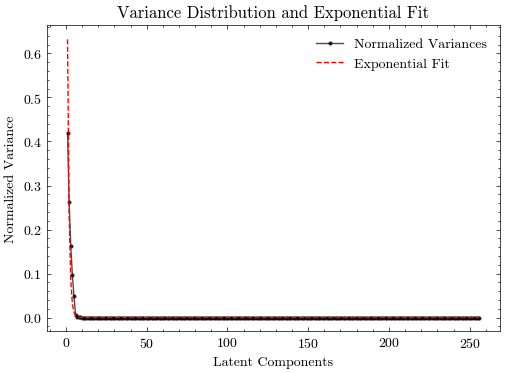

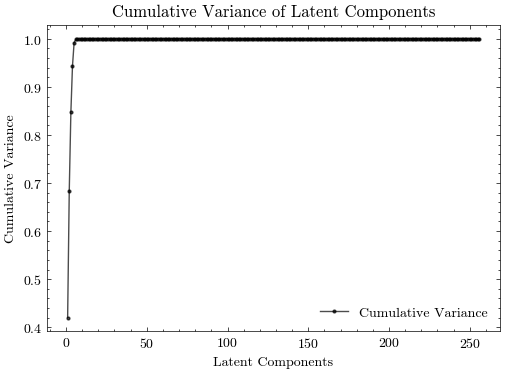

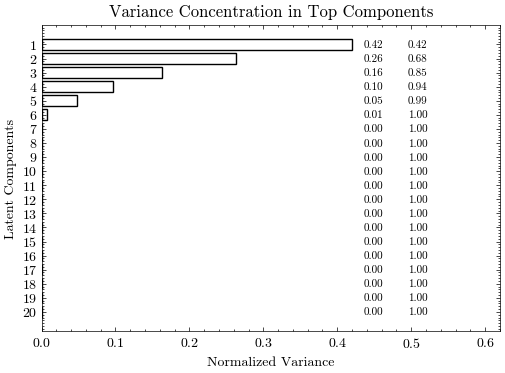

In [27]:
variance_test_analysis(model_conv, data)

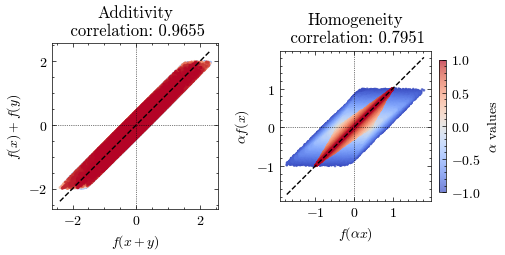

In [28]:
linearity_tests_analysis(model_conv, data)